<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education - EA  Python Course Spring 2021

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.
6. When you create a figure, comment out `plt.show()` to ensure the autograder can grade your plots. For figure cells, DO NOT DELETE the code that says `DO NOT REMOVE LINE BELOW`.

```
### DO NOT REMOVE LINE BELOW ###
student_plot1_ax = nb.convert_axes(plt)
```

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Your Name:** Adam Mansur

<img style="float: left;" src="colored-bar.png"/>

---

# Week 04 and 05 Homework - Automate NDVI Workflow

For this assignment, you will write code to generate a plot of the mean normalized difference vegetation index (NDVI) for two different sites in the United States across one year of data:

* San Joaquin Experimental Range (SJER) in Southern California, United States
* Harvard Forest (HARV) in the Northeastern United States

The data that you will use for this week is available from **earthpy** using the following download: 

`et.data.get_data('ndvi-automation')`

## Assignment Goals

Your goal in this assignment is to create the most efficient and concise workflow that you can that allows for:

1. The code to scale if you added new sites or more time periods to the analysis.
2. Someone else to understand your workflow.
3. The LEAST and most efficient (i.e. runs fast, minimize repetition) amount of code that completes the task.

### HINTS

* Remove values outside of the landsat valid range of values as specified in the metadata, as needed.
* Keep any output files SEPARATE FROM input files. Outputs should be created in an outputs directory that is created in the code (if needed) and/or tested for.
* Use the functions that we demonstrated during class to make your workflow more efficient.
* BONUS - if you  chose - you can export your data as a csv file. You will get bonus points for doing this.


## Assignment Requirements

Your submission to the GitHub repository should include:
* This Jupyter Notebook file (.ipynb) with:
    * The code to create a plot of mean NDVI across a year for  2 NEON Field Sites:
        * NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object
    * The **data should be cleaned to remove the influence of clouds**. See the [earthdatascience website for an example of what your plot might look like with and without removal of clouds](https://www.earthdatascience.org/courses/earth-analytics-python/create-efficient-data-workflows/).
* BONUS: Create one output `.csv` file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV.

Your notebook should:
* Have *at least* 2 well documented and well named functions with docstrings.
* Include a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code)
* Include additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Replace this cell with your pseudocode  for this workflow

If you happen to be a diagram person a diagram is ok too



# Pseudocode

*The cell above is locked*

+ Identify and iterate through 2017 Landstat tilesets for HARV and
  SJER sites. For each site:
    + Read the site boundary vector file
    + For each scene:
        + Read and label red, NIR, and QA bands
        + Remove extreme values
        + Crop bands to site boundary
        + Remove clouds and cloud shadows
        + Calculate NDVI and mean NDVI
        + Parse acquisition date from Landsat file names
        + Create dataframe with site name, date, and mean NDVI
+ Concatenate individual dataframes into a single dataframe
+ Plot NDVI over time for both sites 
    

# Approach

The functions for reading, cropping, and masking Landsat data were combined
into an xarray accessor class called LandsatAccessor. The accessor structure is
the recommended way to extend xarray objects. I chose this approach because:

1. I've found it difficult to keep track of what's going on when cleaning and
   plotting data using xarray. Many of the procedures require remembering to use
   functions I don't really understand (like plotting_extent) or process bands
   using list indices that could vary depending on exactly how the data was read.
   This makes it hard to re-use code or remember how to make various plots. The
   accessor shifts some of the confusing bits (like deriving and applying the
   cloud QA mask) behind the scenes.
2. The functions I came up with are more readable/reproducible if the Landsat
   data is read in a specific way (for example, with the band attribute set to
   match the original band number instead of the read order). That is a good
   case for bundling methods in a class.
   
Some other things I like about this approach include that it:

+ Allows access to individual bands by name (red, green, blue, nir)
+ Clarifies calculations like NDVI by explicitly naming the bands involved
+ Compiles Landsat-related logic inside a single class (plus a helper function
  used to read the Landsat images) that are available from any xarray object

Drawbacks to this approach include:

+ The ad hoc attributes required to use the accessor methods are not always
  carried over by array operations, so the accessor is somewhat brittle. This
  is a limitation of xarray, which prioritizes letting calcualtions run over
  preserving metadata.
+ The accessor currently only works on Landsat data. Currently Landsat-specific
  logic is used for mapping bands to colors, reading metadata, and masking
  using the QA layer. The first thing could be generalized, but not the other
  two seem to depend heavily on the exact satellite producing the data.
+ Length of code is excessive for the current assignment

The code isn't optimized besides really basic stuff like using built-in array
functions. The loop used to look for all HARV and SJER data should scale.

In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

In [2]:
# Import needed packages in PEP 8 order
# and no unused imports listed (10 points total)
from glob import glob
import os
import re

import earthpy as et
import earthpy.mask as em
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rioxarray as rxr
import xarray as xr




# Increase default font size on all plots
sns.set(font_scale=1.5)

# Download NDVI automation dataset
et.data.get_data("ndvi-automation")

# Set working directory
os.chdir(os.path.join(et.io.HOME, "earth-analytics", "data"))

In [3]:
# DO NOT MODIFY THIS CELL
# Tests that the working directory is set to earth-analytics/data

path = os.path.normpath(os.getcwd())
student_wd_parts = path.split(os.sep)

if student_wd_parts[-2:] == ['earth-analytics', 'data']:
    print("\u2705 Great - it looks like your working directory is set correctly to ~/earth-analytics/data")
else:
    print("\u274C Oops, the autograder will not run unless your working directory is set to earth-analytics/data")

✅ Great - it looks like your working directory is set correctly to ~/earth-analytics/data


# Figure 1: Plot 1 - Mean NDVI For Each Site Across the Year (50 points)

Create a plot of the mean normalized difference vegetation index (NDVI) for the two different sites in the United States across the year: 

* NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object.
* Each site should be identified with a different color in the plot and legend.
* The final plot **data should be cleaned to remove the influence of clouds**.
* Be sure to include appropriate title and axes labels.

Add additional cells as needed for processing data (e.g. defining functions, etc), but be sure to:
* follow the instructions in the code cells that have been provided to ensure that you are able to use the sanity check tests that are provided. 
* include only the plot code in the cell identified for the final plot code below

## Task 1: 

In the cell below, create a single dataframe containing MEAN NDVI, the site name, 
and the date of the data for the HARV site 
scene `HARV/landsat-crop/LC080130302017031701T1-SC20181023151837`.  The column names for the  final
DataFrame should be`mean_ndvi`, and `site`, and the data should be **indexed on the date**. 

Use the functions that we reviewed in class (or create your own versions of them) to implement your code

### In the Cell below Place  All Functions Needed to Run this Notebook (20 points)

In [4]:
### DO NOT REMOVE THIS LINE OR EDIT / MOVE THIS CELL ###
start_time = datetime.now()

In [5]:
# In this cell place all of the functions needed to run your notebook
# You will be graded here on function application, docstrings, efficiency so ensure
# All functions are placed here!


@xr.register_dataarray_accessor("landsat")
class LandsatAccessor:
    """Extends data array to parse and run common calculations on Landsat data
    
    Attributes
    ----------
    red : xarray DataArray
        red band
    green : xarray DataArray
        green band
    blue : xarray DataArray
        blue band
    nir : xarray DataArray
        near-infrared band
    qa : xarray DataArray
        pixel qa band
    metadata : dict
        Landsat metadata parsed from filename
    """
    
    def __init__(self, xarr):
        self._obj = xarr
        self._metadata = None
        self._names = {
            2: "blue",
            3: "green",
            4: "red",
            5: "nir",
        }
    
    
    @property
    def blue(self):
        return self._obj.sel(band=2)
    
    
    @property
    def green(self):
        return self._obj.sel(band=3)
    
    
    @property
    def red(self):
        return self._obj.sel(band=4)
    
    
    @property
    def nir(self):
        return self._obj.sel(band=5)
    
    
    @property
    def qa(self):
        return self._obj.sel(band="qa")
    
    
    @property
    def metadata(self):
        """Returns Landsat metadata, deriving it from a filename if needed
        
        Metadata parsing is deferred so that non-Landsat arrays don't get
        tripped up by the parse function when they are created.
        """
        if self._metadata is None:
            self._metadata = self._parse_product_id()
        return self._metadata
 
    
    def clean_all_bands(self, **kwargs):
        """Cleans all bands in the array
        
        Arguments
        ---------
        kwargs:
            any keyword argument accepted by clean_band()
            
        Returns
        -------
        xarray DataArray
            Array with out-of-range data set to nan 
        """
        # Clean each band and build a new DataArray
        out_xr = []
        for arr in self._obj:
            if arr.band != "qa":
                out_xr.append(self.clean_band(arr, **kwargs))
        out_xr.append(self.qa.copy())

        return xr.concat(out_xr, dim="band")
    
    
    def mask_qa_pixels(self, flags):
        """Masks array based on Landsat QA pixel flags
        
        Arguments
        ---------
        flags : list-like
            list of pixel QA flags to mask
        
        Returns
        -------
        xarray DataArray
            Array with specified features set to nan
        """
        
        # Format key for earthy.mask lookup from satellite number
        key = "L{}".format(self.metadata["satellite"].lstrip("0"))
        
        # Read pixel values for specified flags
        mask = []
        for flag in flags:
            mask.extend(em.pixel_flags["pixel_qa"][key][flag])
            
        # Mask each data band separately and build a new DataArray
        out_xr = []
        for arr in self._obj:
            if arr.band != "qa":
                out_xr.append(arr.where(~self.qa.isin(mask)))
                
                # Ad hoc attributes are lost here, so set them manually.
                out_xr[-1]["band"] = arr.band
                out_xr[-1]["path"] = arr.path
        
        out_xr.append(self.qa.copy())

        return xr.concat(out_xr, dim="band")

    
    def mask_clouds(self):
        """Masks clouds in an array (Landsat 8 only)
        
        Returns
        -------
        xarray DataArray
            Array with cloud features set to nan
        """
        return self.mask_qa_pixels(
            ["Cloud", "Cloud Shadow", "High Cloud Confidence"]
        )
    
    
    def ndvi(self):
        """Calculates NDVI using the named NIR and red bands
        
        Returns
        -------
        xarray DataArray
            Array containing NDVI values
        """
        return (self.nir - self.red) / (self.nir + self.red)
    
    
    def plot_bands(self, **kwargs):
        """Plots all bands in the array
        
        Arguments
        ---------
        kwargs:
            any keyword argument accepted by ep.plot_bands(). The title
            arguments is provided if not given.
            
        Returns
        -------
        None
        """
        # Set default titles for each band
        bands = [a.band.values[()] for a in self._obj]
        kwargs.setdefault("title", [self._names.get(b, b) for b in bands])
        
        ep.plot_bands(self._obj, **kwargs)

    
    @staticmethod
    def clean_band(band, valid_range=None):
        """Cleans a single Landsat band

        Parameters
        -----------
        band : str or array
            Either an array or the path to the array to be opened
        valid_range : tuple (optional)
            A tuple of min and max range of values for the data. Default = None


        Returns
        -----------
        xarray DataArray
            Array with out-of-range values set to nan
        """
        # Read band from file if passed as a string
        if isinstance(band, str):
            band = rxr.open_rasterio(band_path, masked=True).squeeze()

        # Remove pixels outside valid range if provided
        if valid_range:
            mask = ((band < min(valid_range)) | (band > max(valid_range)))
            band = band.where(~xr.where(mask, True, False))

        return band
    
    
    def _parse_product_id(self):
        """Parses acquisition and processing info from Landsat filename
        
        Returns
        -------
        dict
            Dictionary containing the parsed metadata
        """
        prod_id = os.path.basename(self._obj[0].path.values[()])
        sat, corr, wrs, acq, proc, coll_num, coll_cat = prod_id.split("_")[:7]
        
        return {
            "sensor": sat[1],
            "satellite": sat[3:],
            "wrs_path": wrs[:3],
            "wrs_row": wrs[3:],
            "acq_date": datetime.strptime(acq, "%Y%m%d"),
            "proc_date": datetime.strptime(proc, "%Y%m%d"),
            "coll_num": coll_num,
            "coll_cat": coll_cat  
        }  

    
    
    
def open_landsat(path, min_band=1, max_band=7):
    """Combines Landsat TIFFs in a directory into an xarray
    
    Also adds two ad hoc attributes, band and path. Some methods, like
    arr.where(), seem to lose track of these attributes in some cases.

    Arguments
    ---------
    path : str
        path to directory containing a set of Landsat TIFFs
    min_band: int
        minimum band to retrieve
    max_band: int
        maximum band to retrieve

    Returns
    -------
    xarray DataArray
         Array merging all matching TIFFs into one object

    Raises
    ------
    IOError
        If wrong number of bands found
    """

    # Read TIFFs along path matching selected bands, then add the QA band
    paths = []
    for fp in glob(os.path.join(path, f"*band[{min_band}-{max_band}]*.tif")):
        paths.append(fp)
    paths.sort()
    paths.extend(glob(os.path.join(path, f"*pixel_qa*.tif")))
    
    # Raise an error if any of the expected bands are missing
    expected = (max_band - min_band + 2)
    if len(paths) != expected:
        raise IOError(f"Wrong number of TIFFs found on {os.path.abspath(path)}"
                      f" (found {len(paths)}, expected={expected})")

    # Combine ordered list of TIFFs into an xarray
    out_xr =[]
    for fp in paths:
        out_xr.append(rxr.open_rasterio(fp, masked=True).squeeze())

        # Add min_band so that the band id matches original Landsat band
        out_xr[-1]["band"] = len(out_xr) + min_band - 1
        out_xr[-1]["path"] = os.path.realpath(fp)

    # Rename the last band to "qa"
    out_xr[-1]["band"] = "qa"

    return xr.concat(out_xr, dim="band")



def mean_ndvi_from_landsat(path, site_name, site_boundary=None):
    """Calculates mean NDVI for a set of Landsat images
    
    Arguments
    ---------
    path: str
        path to directory containing a set of Landsat images
    site_name : str
        name of the site imaged by Landsat
    site_boundary : str or geopandas.GeoDatafFrame
        boundary of the site as either a path to a shapefile or GeoDataFrame

    Returns
    -------
    pandas DataFrame
        Date-indexed dataframe with the mean NDVI from the Landsat data
    """
    arr = open_landsat(path, min_band=4, max_band=5)
    
    # Clip site to boundary
    if site_boundary is not None:
        
        # Read boundary from file if string given
        if isinstance(site_boundary, str):
            site_boundary = gpd.read_file(site_boundary)
        
        # Align CRS if not the same
        if arr.rio.crs != site_boundary.crs:
            site_boundary = site_boundary.to_crs(arr.rio.crs)
        
        arr = arr.rio.clip(site_boundary.geometry)
        
    # Remove extreme values from all bands
    arr = arr.landsat.clean_all_bands(valid_range=(0, 10000))
    
    # Mask clouds
    arr = arr.landsat.mask_clouds()
    
    # Return a data-indexed dataframe with the mean NDVI for the dataset
    return pd.DataFrame({
            "site": site_name,
            "mean_ndvi": float(arr.landsat.ndvi().mean())
        },
        index=[arr.landsat.metadata["acq_date"]]
    )
    
    
    

### Data sources

Data for the following calculation of NDVI was collected by the Landsat 8 
satellite in March 2017 at the HARV field site as part of the NEON program.

In [6]:
# Create dataframe of mean NDVI in this cell using the functions created above
# Important: to use the ungraded tests below as a sanity check,
# name your columns: mean_ndvi and site
# Call the dataframe at the end of the cell so the tests run on it!
# Be sure that the date column is an index of type date
# HINT: the time series lessons may help you remember how to do this!

# Define path to HARV folder
harv_path = os.path.join("ndvi-automation", "sites", "HARV")

# Define path to HARV site boundary
harv_bound_path = os.path.join(harv_path, "vector", "HARV-crop.shp")

# Define path to specific dataset
harv_20170317_path = os.path.join(
    harv_path, "landsat-crop", "LC080130302017031701T1-SC20181023151837"
)

# Calculate mean NDVI
harv_20170317_mean_ndvi = mean_ndvi_from_landsat(
    harv_20170317_path, "HARV", harv_bound_path
)
harv_20170317_mean_ndvi


,site,mean_ndvi
2017-03-17,HARV,0.281132


In [7]:
# This cell  is testing your data output above

student_ndvi_ts_single_site = _

single_scene_points = 0

# Ensure the data is stored in a dataframe.
if isinstance(student_ndvi_ts_single_site, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    single_scene_points += 1
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Ensure that the date column is the index
if isinstance(student_ndvi_ts_single_site.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    single_scene_points += 2
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_ts_single_site.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    single_scene_points += 2
else:
    print('\u274C The data in your date column is not datetime.')

# Ensure the site name is correct
if student_ndvi_ts_single_site.site.values[0] == 'HARV':
    print('\u2705 You have the correct site name!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct site name.')

if np.allclose(0.281131628228094, student_ndvi_ts_single_site.mean_ndvi.values[0]):
    print('\u2705 You have the correct mean NDVI value!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct mean ndvi value.')

print("\n \u27A1 You received {} out of 15 points for creating a dataframe.".format(
    single_scene_points))
single_scene_points

✅ Your data is stored in a DataFrame!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
✅ You have the correct site name!
✅ You have the correct mean NDVI value!

 ➡ You received 15 out of 15 points for creating a dataframe.


15

## Task 2:

In the cell below, process all of the landsat scenes. Create a DataFrame that contains the following 
information for each scene


|   | index  | site  | mean_ndvi  | 
|---|---|---|---|
| Date  |   |   |   |
|  2017-01-07  | 0  | SJER  | .4  |  

Be sure to call your dataframe at the end of the cell to ensure autograding works.
HINT: FOR THIS STEP, leave any rows containing missing values (`NAN`).

### Data sources

Data for the following calculation of NDVI was collected by the Landsat 8
satellite in 2017 for the HARV and SJER field sites as part of the NEON program.

In [8]:
# Create dataframe of NDVI including the cleaning data to deal with clouds

# Important: to use the ungraded tests below as a sanity check,
# name your columns: mean_ndvi and site
# Don't forget to set date as the index and make the values of type datetime

# Define path to SJER folder (the path to HARV is defined above)
sjer_path = os.path.join("ndvi-automation", "sites", "SJER")

# Read boundaries for each site
boundaries = {
    "HARV": gpd.read_file(os.path.join(harv_path, "vector", "HARV-crop.shp")),
    "SJER": gpd.read_file(os.path.join(sjer_path, "vector", "SJER-crop.shp"))
}

# Calculate NDVI for each scene
ndvi_by_scene = []
for root, dirs, files in os.walk(os.path.join("ndvi-automation", "sites")):
    if os.path.basename(root).startswith("LC08"):
        # Grab site name from root and process scene
        site_name = re.search(r"\b[A-Z]{4}\b", root).group()
        ndvi_by_scene.append(
            mean_ndvi_from_landsat(root, site_name, boundaries[site_name])
        )
        
mean_ndvi_all = pd.concat(ndvi_by_scene).sort_index()
mean_ndvi_all

,site,mean_ndvi
2017-01-07,SJER,NaN
2017-01-12,HARV,NaN
2017-01-23,SJER,NaN
2017-01-28,HARV,NaN
2017-02-08,SJER,NaN
2017-02-13,HARV,NaN
2017-02-24,SJER,0.665524
2017-03-01,HARV,NaN
2017-03-12,SJER,0.664109
2017-03-17,HARV,0.281132


In [9]:
# Last sanity check before creating your plot (10 points)

# Ensure that you call your dataframe at the bottom of the cell above
# and that it has columns called: mean_ndvi and site

# Ensure the data is stored in a dataframe.
student_ndvi_df = _

df_points = 0

if isinstance(student_ndvi_df, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    df_points +=2
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Check that dataframe contains the appropriate number of NAN values
if student_ndvi_df.mean_ndvi.isna().sum() == 15:
    print('\u2705 Correct number of masked data values!')
    df_points +=2
else:
    print('\u274C The amount of null data in your dataframe is incorrect.')


# Ensure that the date column is the index
if isinstance(student_ndvi_df.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    df_points +=3
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_df.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    df_points +=3
else:
    print('\u274C The data in your date column is not datetime.')

# Output for timer, # DO NOT MODIFY
end_time = datetime.now()
total_time = end_time - start_time
print(
    "Your total run time for processing the data was {0}.".format(total_time))

print("\n \u27A1 You received {} out of 10 points for creating a dataframe.".format(
    df_points))

df_points

✅ Your data is stored in a DataFrame!
✅ Correct number of masked data values!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
Your total run time for processing the data was 0:00:23.024782.

 ➡ You received 10 out of 10 points for creating a dataframe.


10

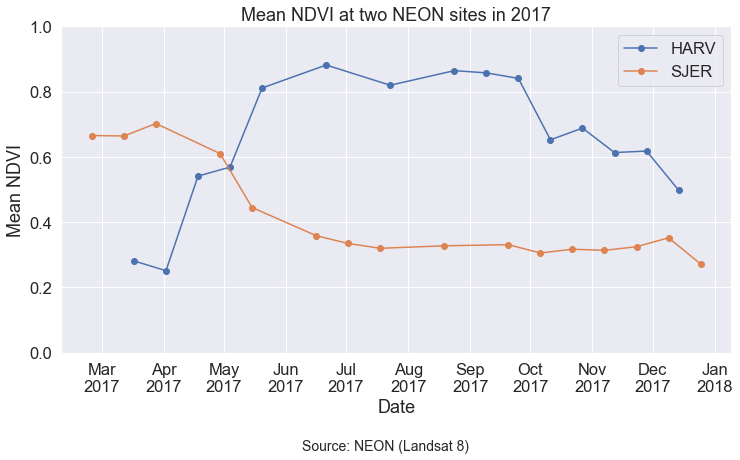

In [10]:
# Add only the plot code to this cell

# This is the final figure of mean NDVI
# for both sites across the year
# with data cleaned to deal with clouds

# Remove null NDVIs so lines connect all points
mean_ndvi_sub = mean_ndvi_all.dropna(how="any", axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set(
    title="Mean NDVI at two NEON sites in 2017",
    xlabel="Date",
    ylabel="Mean NDVI",
    ylim=(0, 1)
)

# Plot scenes for each site as a line
for site, rows in mean_ndvi_sub.groupby("site"):
    ax.plot(rows.index, rows.mean_ndvi, marker="o", label=site)

# Use short month names to label the x axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y')) 

ax.legend()

fig.text(0.5, -0.1, f"Source: NEON (Landsat 8)", fontsize=14, ha="center")

### DO NOT REMOVE LINES BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")

In [11]:
# Ignore this cell for the autograding tests


In [12]:
# Ignore this cell for the autograding tests


# Question 1 (10 points)

Imagine that you are planning NEON’s upcoming flight season to capture remote sensing data in these locations and want to ensure that you fly the area when the vegetation is the most green.

When would you recommend the flights take place for each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

Healthy, green vegetation will show a moderate to high NDVI. The highest NDVI (and
therefore greenest vegeation) occurred at the SJER site between March and mid-April
and at the HARV site between mid-May and late September, so those would be the best
windows for scheduling flights.

# Question 2 (10 points)

How could you modify your workflow to look at vegetation changes over time in each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

One approach would be to compare results from periods of high and low NDVI. For SJER,
that would mean scheduling a flight for sometime between July and December in addition
to the high NDVI flight above. For HARV, the low NDVI flight would be scheduled for
March to April (and possibily earlier since data from January and February are not
available but NDVI at this site is trending down in December).

# Do not edit this cell! (10 points)

The notebook includes:
* additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

## BONUS - Export a  .CSV File to Share (10 points possible)

This is optional - if you export a **.csv** file with the columns specified above: Site, Date and NDVI Value you can get an additional 10 points.

* FULL CREDIT: File exists in csv format and contains the columns specified.
We will check your github repo for this file!


In [13]:
# Export CSV with mean NDVI to outputs folder
mean_ndvi_all.to_csv(os.path.join("ndvi-automation", "outputs", "mean_ndvi.csv"),
                     header=["Site", "NDVI Value"],
                     index_label="Date")